In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import io
import re
import nltk
import json
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import random

In [2]:
with open("interviewku-chatbot-v2.json") as file:
  dataset = json.load(file)

In [3]:
def processing_json_dataset(dataset):
    tags = []
    inputs = []
    responses={}
    for intent in dataset:
        responses[intent['tag']]=intent['responses']
        for lines in intent['patterns']:
            inputs.append(lines)
            tags.append(intent['tag'])
    return [tags, inputs, responses]

blacklist_word = ['wawancara', 'interview']
# replace_word = [
#     ['remote', ['daring', 'remote']],
#     ['', ['']],
#     ['', ['']],
# ]
def preprocessing_text(sentence):
    filtered_words = re.sub(r'[^\w\d\s]', '', sentence.lower())
    words = word_tokenize(filtered_words)
    words = [word for word in words if word.lower() not in blacklist_word]
    return ' '.join(words)
    
preprocessing_text('Halo!, apa yang harus disiapkan sebelum wawancara?')

'halo apa yang harus disiapkan sebelum'

In [4]:
[tags, inputs, responses] = processing_json_dataset(dataset)

In [5]:
dataset = pd.DataFrame({"inputs":inputs, "tags":tags})
dataset = dataset.sample(frac=1)
dataset['inputs'] = [preprocessing_text(sentence) for sentence in dataset['inputs']]

In [6]:
tokenizer_json_file = '../../word_dict/word_dictionary.json'
with open(tokenizer_json_file, 'r') as f:
    tokenizer_config = json.load(f)
tokenizer_array = tokenizer_config.keys()

tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(tokenizer_array)
word_index = tokenizer.word_index
print(len(word_index))

90014


In [7]:
# Converting the data into sequences and give a padding
le = LabelEncoder()

tokenizer.fit_on_texts(dataset['inputs'])
training_sequences = tokenizer.texts_to_sequences(dataset['inputs'])
training_padded = pad_sequences(training_sequences)

training_labels = le.fit_transform(dataset['tags'])

In [8]:
print(len(training_padded[0]))
print(training_padded.shape)

13
(59, 13)


In [9]:
vocabulary = len(tokenizer.word_index)
print("number of unique words : ",vocabulary)
output_length = le.classes_.shape[0]
print("output length: ",output_length)

number of unique words :  90020
output length:  28


## Build RNN Model

<img src="https://i.imgur.com/Rmx67pA.png" />

In [ ]:
https://www.researchgate.net/publication/342039054_Convolutional_layers_with_Keras

In [10]:
glove_dir = "../../glove.6B/glove.6B.100d.txt"
embeddings_index = {}
file_ = open(glove_dir, encoding="utf8")
for line in file_:
    arr = line.split()
    single_word = arr[0]
    w = np.asarray(arr[1:],dtype='float32')
    embeddings_index[single_word] = w
file_.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [11]:
max_words = vocabulary + 1
word_index = tokenizer.word_index
embedding_matrix = np.zeros((max_words,100)).astype(object)
for word , i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [30]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(training_padded.shape[1])),
    tf.keras.layers.Embedding(input_dim=vocabulary+1, output_dim=100, weights=[embedding_matrix], trainable=False),
    tf.keras.layers.Conv1D(
        filters=32,
        kernel_size=5,
        activation="relu",
        kernel_initializer=tf.keras.initializers.GlorotNormal(),
        bias_regularizer=tf.keras.regularizers.L2(0.00005),
        kernel_regularizer=tf.keras.regularizers.L2(0.00005),
        activity_regularizer = tf.keras.regularizers.L2(0.00005)
    ),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(32, dropout=0.2,return_sequences=True),
    tf.keras.layers.LSTM(16, dropout=0.2,return_sequences=False),
    # tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128,activation="relu", activity_regularizer = tf.keras.regularizers.L2(0.00005)),
    tf.keras.layers.Dense(output_length, activation="softmax", activity_regularizer = tf.keras.regularizers.L2(0.00005))
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 13, 100)           9002100   
                                                                 
 conv1d_3 (Conv1D)           (None, 9, 32)             16032     
                                                                 
 dropout_5 (Dropout)         (None, 9, 32)             0         
                                                                 
 lstm_6 (LSTM)               (None, 9, 32)             8320      
                                                                 
 lstm_7 (LSTM)               (None, 16)                3136      
                                                                 
 dense_6 (Dense)             (None, 128)               2176      
                                                                 
 dense_7 (Dense)             (None, 28)               

In [31]:
# from keras.callbacks import TensorBoard, EarlyStopping

model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

class Callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('loss') < 0.1 and logs.get('accuracy') > 0.99:
            self.model.stop_training = True

# earlyStopping = EarlyStopping(monitor = 'loss', patience = 400, mode = 'min', restore_best_weights = True)
history = model.fit(training_padded, training_labels, epochs=1000, batch_size=64, callbacks=[Callback()])

Epoch 1/1000
1/1 [==============================] - 2s 2s/step - loss: 3.3354 - accuracy: 0.0508
Epoch 2/1000
1/1 [==============================] - 0s 12ms/step - loss: 3.3342 - accuracy: 0.0339
Epoch 3/1000
1/1 [==============================] - 0s 11ms/step - loss: 3.3304 - accuracy: 0.0847
Epoch 4/1000
1/1 [==============================] - 0s 13ms/step - loss: 3.3288 - accuracy: 0.0678
Epoch 5/1000
1/1 [==============================] - 0s 11ms/step - loss: 3.3261 - accuracy: 0.0508
Epoch 6/1000
1/1 [==============================] - 0s 12ms/step - loss: 3.3257 - accuracy: 0.0508
Epoch 7/1000
1/1 [==============================] - 0s 11ms/step - loss: 3.3234 - accuracy: 0.0508
Epoch 8/1000
1/1 [==============================] - 0s 10ms/step - loss: 3.3189 - accuracy: 0.0678
Epoch 9/1000
1/1 [==============================] - 0s 11ms/step - loss: 3.3195 - accuracy: 0.0678
Epoch 10/1000
1/1 [==============================] - 0s 11ms/step - loss: 3.3153 - accuracy: 0.0508
Epoch 11/10

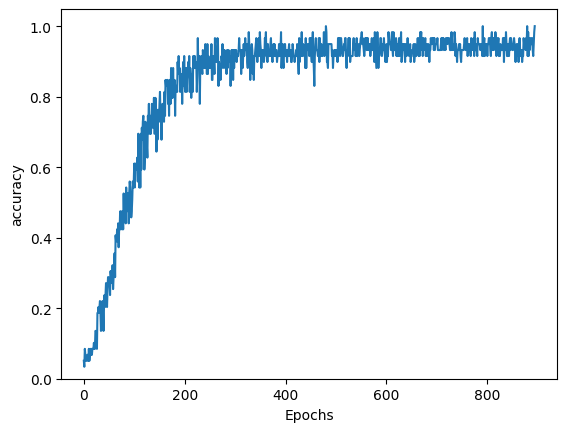

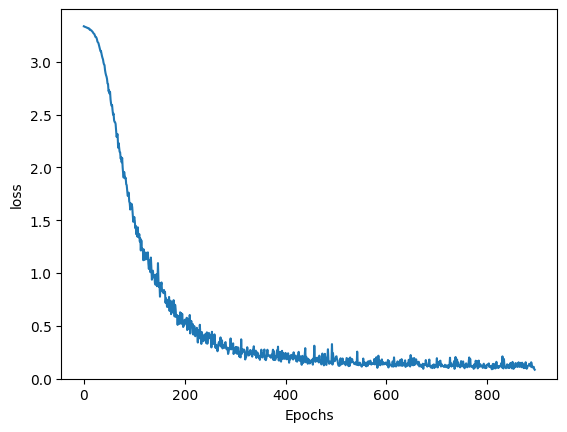

In [32]:
# Declare graph function
def plot_graphs(history, string):
    plt.plot(history.history[string])
    # plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    # plt.legend([string, 'val_'+string])
    plt.ylim(bottom=0)
    plt.show()
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [33]:
import random
def generate_answer(input):
    input = preprocessing_text(input)
    input = tokenizer.texts_to_sequences([input])
    input = np.array(input).reshape(-1)
    input = pad_sequences([input], training_padded.shape[1])
    output = model.predict(input, verbose=0)
    
    # output_prob = output[0]  # Mengambil probabilitas untuk sampel pertama (satu-satunya sampel dalam kasus ini)
    # max_prob = max(output_prob)  # Mengambil nilai probabilitas tertinggi
    # percentage = max_prob * 100  # Mengonversi nilai probabilitas menjadi persentase
    # print(f"Persentase hasil prediksi: {percentage:.2f}%")

    output = output.argmax()
    response_tag = le.inverse_transform([output])[0]
    print(response_tag)

    return random.choice(responses[response_tag])

In [34]:
generate_answer('apa yang harus disiapkan sebelum wawancara')

Persiapan_Wawancara


'Sebelum melakukan wawancara, pastikan untuk mempersiapkan CV, portfolio, dan pertanyaan untuk pewawancara. Selain itu, lakukan riset tentang perusahaan dan posisi yang dilamar, dan pastikan untuk mempersiapkan penampilan dan sikap yang profesional.'

In [35]:
generate_answer('cara membuat cv yang bagus')

CV_Tips


'Untuk membuat CV yang bagus, Anda bisa memperhatikan beberapa poin seperti penulisan ringkas, penggunaan bahasa yang jelas, penekanan pada pengalaman relevan, dan tata letak yang bersih dan mudah dibaca.'

In [36]:
generate_answer('cara menjawab saat ditanyakan gaji yang diminta')

Salary_Question


'Bernegosiasi gaji adalah hal yang umum. Lakukan riset tentang kisaran gaji yang sesuai dengan posisi dan pengalaman Anda. Sampaikan secara jelas keinginan Anda, tetapi berikan ruang untuk bernegosiasi.'

In [37]:
generate_answer('portofolio seperti apa yang bagus?')

Menyusun_Portfolio


'Portfolio adalah alat yang baik untuk menunjukkan karya atau proyek Anda. Sertakan proyek yang relevan, dokumentasi yang jelas, dan ceritakan bagaimana Anda berkontribusi dalam setiap proyek tersebut.'

In [38]:
generate_answer('tips sebelum wawancara')

Wawancara_Tips


'Beberapa tips sebelum wawancara yang bisa membantu adalah melakukan riset tentang perusahaan, latihan menjawab pertanyaan umum, mempersiapkan pertanyaan untuk pewawancara, dan memastikan penampilan dan sikap yang profesional.'

In [39]:
generate_answer('cara mengatasi gugup saat sesi wawancara')

Menjawab_Pertanyaan_Wawancara


'Untuk memberikan jawaban yang baik, dengarkan pertanyaan dengan seksama, berikan jawaban yang jelas dan konkret, dan tunjukkan contoh dari pengalaman atau keahlian yang relevan dengan pertanyaan tersebut.'

In [40]:
generate_answer('saran tempat lowongan kerja')

Lowongan_Kerja


'Coba eksplorasi situs web seperti LinkedIn, Indeed, dan Glassdoor. Sesuaikan pencarian dengan keahlian dan minat Anda.'

In [41]:
generate_answer('apa yang harus dipersiapkan untuk wawancara online')

Persiapan_Wawancara


'Sebelum melakukan wawancara, pastikan untuk mempersiapkan CV, portfolio, dan pertanyaan untuk pewawancara. Selain itu, lakukan riset tentang perusahaan dan posisi yang dilamar, dan pastikan untuk mempersiapkan penampilan dan sikap yang profesional.'